In [10]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
import numpy as np

In [11]:
# Read the data
df = pd.read_csv('abcnews-date-text.csv', nrows=50000)
df = df.rename(columns={'headline_text': 'text'})
df['text'] = df['text'].astype(str)

# Check the data information
df.info()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Batch processing to generate embeddings
def get_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.extend(outputs.last_hidden_state[:, 0, :].cpu().numpy())
    return embeddings

# Get embeddings
embeddings = get_embeddings_batch(df['text'].tolist())

# Clustering
num_topics = 10
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(embeddings)

# Get the topic labels for each text
df['topic'] = kmeans.labels_

# Display the top 10 texts for each topic
for topic in range(num_topics):
    print(f"Topic {topic}:")
    print(df[df['topic'] == topic]['text'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publish_date  50000 non-null  int64 
 1   text          50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
Topic 0:
1        act fire witnesses must be aware of defamation
2        a g calls for infrastructure protection summit
19             bushfire victims urged to see centrelink
20      businesses should prepare for terrorist attacks
30         council moves to protect tas heritage garden
34                   dargo fire threat expected to rise
39            digital tv will become commonplace summit
45    epa still trying to recover chemical clean up ...
46    expressions of interest sought to build livestock
60                 golf club feeling smoking ban impact
Name: text, dtype: object
Topic 1:
7      aussie qualifier stosur wastes four memphis match
18         

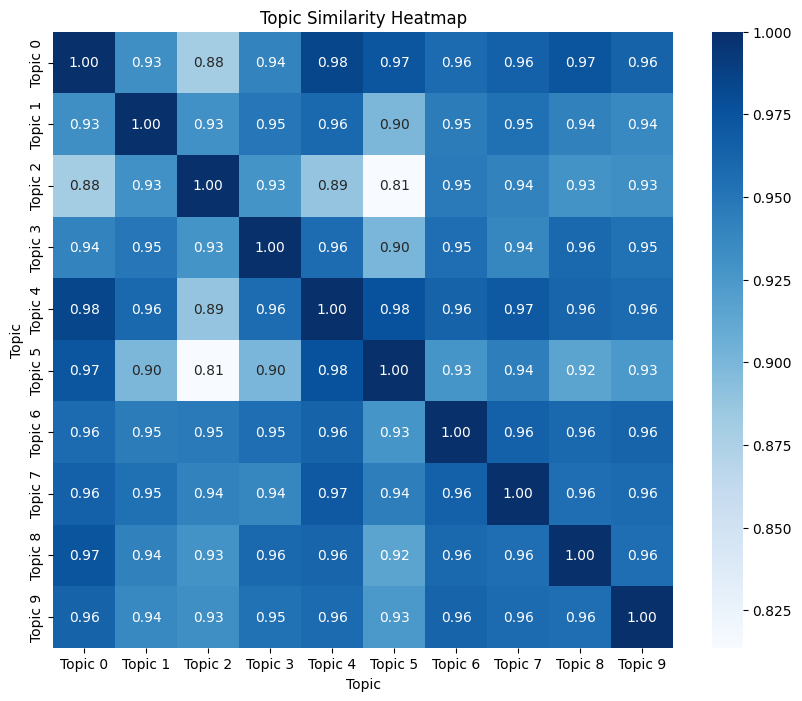

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Convert embeddings to NumPy array
embeddings = np.array(embeddings)

# Calculate the average embedding for each topic
topic_embeddings = np.zeros((num_topics, embeddings.shape[1]))

for topic in range(num_topics):
    topic_embeddings[topic] = np.mean(embeddings[df['topic'] == topic], axis=0)

# Calculate the similarity matrix
similarity_matrix = cosine_similarity(topic_embeddings)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[f'Topic {i}' for i in range(num_topics)],
            yticklabels=[f'Topic {i}' for i in range(num_topics)])
plt.title('Topic Similarity Heatmap')
plt.xlabel('Topic')
plt.ylabel('Topic')
plt.show()